# RAG evaluation

In [1]:
import json
import os
from datetime import datetime

import nest_asyncio
import pandas as pd
import phoenix as px
from openinference.instrumentation.smolagents import SmolagentsInstrumentor
from phoenix.evals import RAG_RELEVANCY_PROMPT_TEMPLATE, GeminiModel, llm_classify
from phoenix.otel import register
from phoenix.trace import SpanEvaluations
from phoenix.trace.dsl import SpanQuery
from smolagents import LiteLLMModel, ToolCallingAgent
from tqdm import tqdm

from travel_agent.qdrant import client as qdrant_client
from travel_agent.retrieval.embedding.embedding_generation import MODELS_PROMPTS
from travel_agent.retrieval.smolagents.tool import TravelReviewQueryTool

if not os.getenv("QDRANT_URL"):
    print("Set QDRANT_URL and QDRANT_API_KEY env")
    exit(1)

print(f"Available embed models:\n- {'\n- '.join(MODELS_PROMPTS.keys())}")

2025-05-01 18:17:13.201 | DEBUG    | travel_agent.qdrant.client:create_client:12 - Connecting to Qdrant at https://21a1c8c4-0d63-4176-9930-ee7848dafd2f.eu-central-1-0.aws.cloud.qdrant.io
2025-05-01 18:17:13.522 | SUCCESS  | travel_agent.qdrant.client:create_client:22 - connected: title='qdrant - vector search engine' version='1.14.0' commit='3617a0111fc8590c4adcc6e88882b63ca4dda9e7'


Available embed models:
- cointegrated/rubert-tiny2
- DeepPavlov/rubert-base-cased-sentence
- ai-forever/sbert_large_nlu_ru
- ai-forever/sbert_large_mt_nlu_ru
- sentence-transformers/distiluse-base-multilingual-cased-v1
- sentence-transformers/distiluse-base-multilingual-cased-v2
- sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
- sentence-transformers/paraphrase-multilingual-mpnet-base-v2
- intfloat/multilingual-e5-large
- intfloat/multilingual-e5-base
- intfloat/multilingual-e5-small
- ai-forever/ru-en-RoSBERTa
- sergeyzh/BERTA


In [2]:
def local_llm(model_name) -> LiteLLMModel:
    return LiteLLMModel(
        model_id=f"ollama_chat/{model_name}",
        api_base=os.getenv("OLLAMA_URL", "http://127.0.0.1:11434"),
        num_ctx=8192,  # ollama default is 2048 which will fail horribly. 8192 works for easy tasks, more is better. Check https://huggingface.co/spaces/NyxKrage/LLM-Model-VRAM-Calculator to calculate how much VRAM this will need for the selected model.
    )


embed_model_name = "intfloat/multilingual-e5-base"
collection_name = "moskva_intfloat_multilingual_e5_base"

review_search_tool = TravelReviewQueryTool(embed_model_name, qdrant_client, collection_name)

2025-05-01 18:17:16.909 | INFO     | travel_agent.retrieval.smolagents.tool:__init__:82 - Using device: mps


In [3]:
saiga_agent = ToolCallingAgent(
    tools=[review_search_tool],
    model=local_llm("hf.co/IlyaGusev/saiga_nemo_12b_gguf:Q4_0"),
    max_steps=10,
)

In [4]:
saiga_agent.run("Привет!")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Привет!                                                                                                         │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/hf.co/IlyaGusev/saiga_nemo_12b_gguf:Q4_0 ───────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': 'Привет!'}                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: Привет!

[Step 1: Duration 1.76 seconds| Input tokens: 1,225 | Output tokens: 23]

'Привет!'

## Set up [Phoenix](https://phoenix.arize.com/) framework to evaluate

https://huggingface.co/blog/smolagents-phoenix

In [5]:
# run in background:
#
# uv run -m phoenix.server.main serve
#
# then run this


project_name = f"travel-agent-eval-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

tracer_provider = register(
    project_name=project_name, auto_instrument=True
)  # creates a tracer provider to capture OTEL traces
SmolagentsInstrumentor().instrument(
    tracer_provider=tracer_provider
)  # automatically captures any smolagents calls as traces

Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: travel-agent-eval-2025-05-01-18-17-31
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [ ]:
questions = pd.read_csv("../data/questions/rag/moskva.csv")

print(questions.shape)

questions.head()

(59, 2)


,question,expected_places
0,Какие 3D-услуги ты знаешь?,"['3ДМолл', 'Икслаб', '3Dcrafter.ru', 'Sprint 3..."
1,Какие GPS-оборудование ты знаешь?,"['Киберкар', 'Виноград Фишинг', 'Навиком', 'Mu..."
2,Какие IP-телефония ты знаешь?,"['Цифра Один', 'Сипнет', 'Инетком', 'Интерлоги..."
3,Какие IT-компания ты знаешь?,"['Oxem', 'DataMobile', 'Ростелеком', 'Квик Ста..."
4,Какие PR-агентство ты знаешь?,"['Фрэш Майнд', 'Blackline', 'Dot Digital Agenc..."


In [15]:
saiga_agent = ToolCallingAgent(
    tools=[review_search_tool],
    model=local_llm("hf.co/IlyaGusev/saiga_nemo_12b_gguf:Q4_0"),
    max_steps=10,
    verbosity_level=0,  # only errors
)

for q in tqdm(questions["question"].tolist()):
    saiga_agent.run(q)

  8%|▊         | 5/59 [00:30<04:56,  5.49s/it]

Error while generating or parsing output:
The model output does not contain any JSON blob.

 19%|█▊        | 11/59 [01:55<08:36, 10.75s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

 63%|██████▎   | 37/59 [08:51<07:15, 19.78s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

 66%|██████▌   | 39/59 [09:39<07:08, 21.41s/it]

Error while generating or parsing output:
Key tool_name_key='name' not found in the generated tool call. Got keys: ['answer'\] instead

100%|██████████| 59/59 [15:16<00:00, 15.54s/it]


In [16]:
query = (
    SpanQuery()
    .where(
        "name == 'TravelReviewQueryTool'",
    )
    .select(
        input="input.value",  # this parameter must be named input to work with the RAG_RELEVANCY_PROMPT_TEMPLATE
        reference="output.value",  # this parameter must be named reference to work with the RAG_RELEVANCY_PROMPT_TEMPLATE
    )
)

# The Phoenix Client can take this query and return the dataframe.
tool_spans = px.Client().query_spans(query, project_name=project_name)

tool_spans["input"] = tool_spans["input"].apply(lambda x: json.loads(x).get("kwargs", {}).get("query", ""))
tool_spans.head()

,input,reference
context.span_id,,
37506f0ddabd6415,Представь топ известных елочных украшений и ви...,Найденные отзывы о местах:\n\n=== Отзыв на Елк...
e5d8760858b02627,Где купить ёлки в России с хорошими отзывами?,Найденные отзывы о местах:\n\n=== Отзыв на ОРТ...
6ed7acd763949391,список ёмкостного оборудования и резервуаров д...,Найденные отзывы о местах:\n\n=== Отзыв на Www...
e87f41818db40953,посоветуй топовые АЗС в России,Найденные отзывы о местах:\n\n=== Отзыв на Лук...
d89fd5d31a865d92,Список аварийных служб,Найденные отзывы о местах:\n\n=== Отзыв на FIT...


In [27]:
print(f"Called tool: {tool_spans.shape[0]} of {questions.shape[0]}")
print(f"Tool calling rate: {tool_spans.shape[0] / questions.shape[0]:.2%}")

Called tool: 45 of 59
Tool calling rate: 76.27%


In [28]:
nest_asyncio.apply()

print(RAG_RELEVANCY_PROMPT_TEMPLATE)


You are comparing a reference text to a question and trying to determine if the reference text
contains information relevant to answering the question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {input}
    ************
    [Reference text]: {reference}
    ************
    [END DATA]
Compare the Question above to the Reference text. You must determine whether the Reference text
contains information that can answer the Question. Please focus on whether the very specific
question can be answered by the information in the Reference text.
Your response must be single word, either "relevant" or "unrelated",
and should not contain any text or characters aside from that word.
"unrelated" means that the reference text does not contain an answer to the Question.
"relevant" means the reference text contains an answer to the Question.


In [29]:
eval_model = GeminiModel(model="gemini-2.0-flash-lite-001", project=659002550737)

eval_results = llm_classify(
    dataframe=tool_spans,
    model=eval_model,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    rails=["relevant", "unrelated"],
    concurrency=10,
    provide_explanation=True,
)
eval_results["score"] = eval_results["explanation"].apply(lambda x: 1 if "relevant" in x else 0)

/var/folders/hy/9y5wfvks4m55vpklg49y7g0r0000gn/T/ipykernel_58057/1446960665.py:5: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  eval_results = llm_classify(


llm_classify |          | 0/45 (0.0%) | ⏳ 00:00<? | ?it/s

In [30]:
eval_results.head()

,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
37506f0ddabd6415,relevant,The question asks for a list of known Christma...,[],COMPLETED,1.895689,1
e5d8760858b02627,relevant,The question asks where to buy Christmas trees...,[],COMPLETED,1.893488,1
6ed7acd763949391,unrelated,The question asks for a list of capacitive equ...,[],COMPLETED,3.171906,1
e87f41818db40953,relevant,The question asks for recommendations of top g...,[],COMPLETED,2.058847,1
d89fd5d31a865d92,unrelated,The question asks for a list of emergency serv...,[],COMPLETED,2.335124,0


In [31]:
px.Client().log_evaluations(SpanEvaluations(eval_name="TravelReviewQueryTool Relevancy", dataframe=eval_results))

count    45.000000
mean      0.644444
std       0.484090
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: score, dtype: float64


<Axes: xlabel='score'>

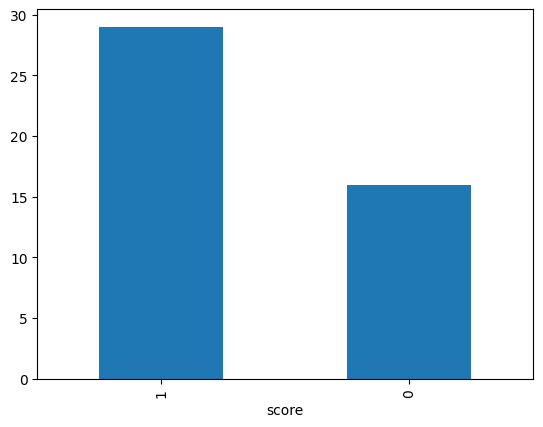

In [ ]:
print(f"Total mean score: {eval_results.score.mean():.4f}")
print(f"Total median score: {eval_results.score.median():.4f}")

print(eval_results.score.describe())

eval_results.score.value_counts().plot.bar()